### **Project work for the course Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

#### Stefano Poggi Cavalletti - 0000982439 - stefano.poggi2@studio.unibo.it

The aim of this project is to perform anomaly detection in time series, in particular on healthcare datasets related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use two available datasets containing ECG data of real patients: ECG5000 and MIT-BIH Arrhythmia Database. In order to be able to distinguish a normal signal from an anomaly, we will use different techniques, like autoencoders and LSTM. In the final part, we will perform classification task.

The ECG5000 dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series (d_x = 1) with 140 timesteps (T = 140). Each sequence corresponds to a single heartbeat from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. The frequency is 60-100 per minute and the duration is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)





In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import json
import copy

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'


train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

We'll combine the training and test data into a single data frame.

In [3]:
df = df_train.append(df_test)

In [4]:
df = df.drop(labels='id', axis=1)

In [5]:
new_columns = list(df.columns)
# target for classification
new_columns[-1] = 'target'
df.columns = new_columns

In [6]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t132,t133,t134,t135,t136,t137,t138,t139,t140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [7]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

### Exploratory Data Analysis

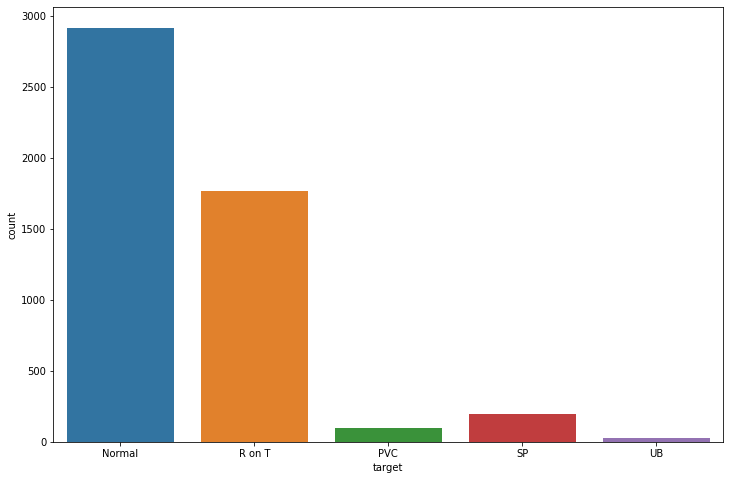

In [8]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,-1], 
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [10]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(X_train[:,:-1])    

In [11]:
X_train[:, :-1] = data_scaled.transform(X_train[:, :-1])
X_test[:, :-1] = data_scaled.transform(X_test[:, :-1])

The normal class, has by far, the most examples. This is great because we'll use it to train our model.
Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [12]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

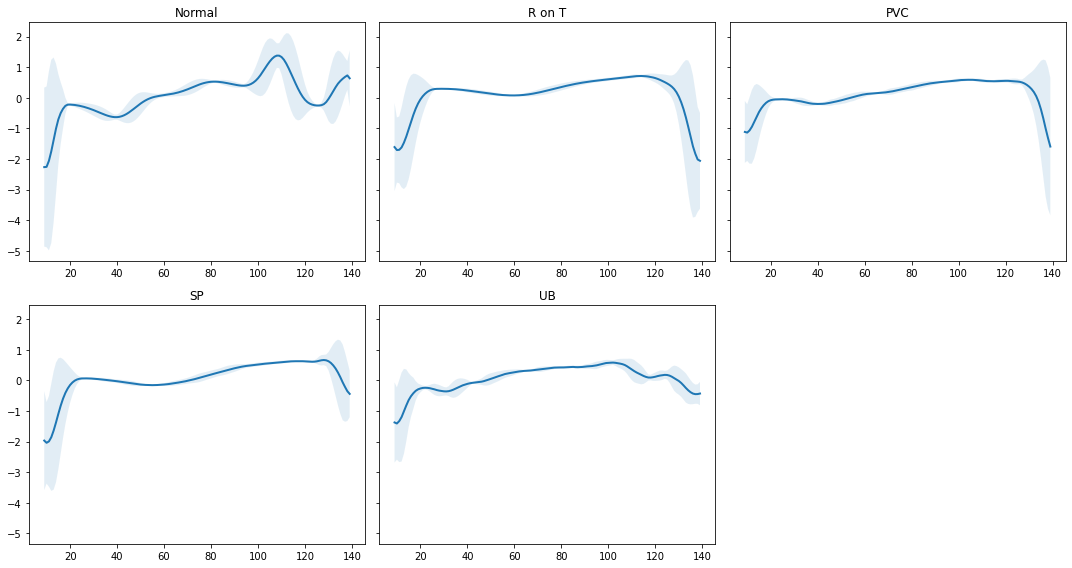

In [13]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(15, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## Autoencoder

 The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.
In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.
To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.
Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

Anomaly Detection in ECG Data
We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [14]:
X_train

array([[0.53813398, 0.59585633, 0.57441253, ..., 0.0569781 , 0.17124168,
        2.        ],
       [0.53857438, 0.58850356, 0.54122911, ..., 0.25063599, 0.22736195,
        2.        ],
       [0.317557  , 0.18654775, 0.09989901, ..., 0.70718614, 0.51703033,
        1.        ],
       ...,
       [0.45442466, 0.35540716, 0.20183108, ..., 0.74294265, 0.50709418,
        1.        ],
       [0.40345124, 0.39132017, 0.34101396, ..., 0.50193227, 0.47770011,
        2.        ],
       [0.37134117, 0.25002207, 0.14875345, ..., 0.65626497, 0.35023474,
        1.        ]])

In [15]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [16]:
normal_X_train = df_train[df_train.iloc[:,-1] == 1].drop(columns=df_train.columns[-1], axis=1).values
normal_X_train.shape

(2333, 140)

In [17]:
normal_X_test = df_test[df_test.iloc[:,-1] == 1].drop(columns=df_test.columns[-1], axis=1).values
normal_X_test.shape

(586, 140)

We'll merge all other classes and mark them as anomalies:

In [18]:
anomaly_X_train = df_train[df_train.iloc[:,-1] > 1].drop(columns=df_train.columns[-1], axis=1).values
anomaly_X_train.shape

(1667, 140)

In [19]:
anomaly_X_test = df_test[df_test.iloc[:,-1] > 1].drop(columns=df_test.columns[-1], axis=1).values
anomaly_X_test.shape

(414, 140)

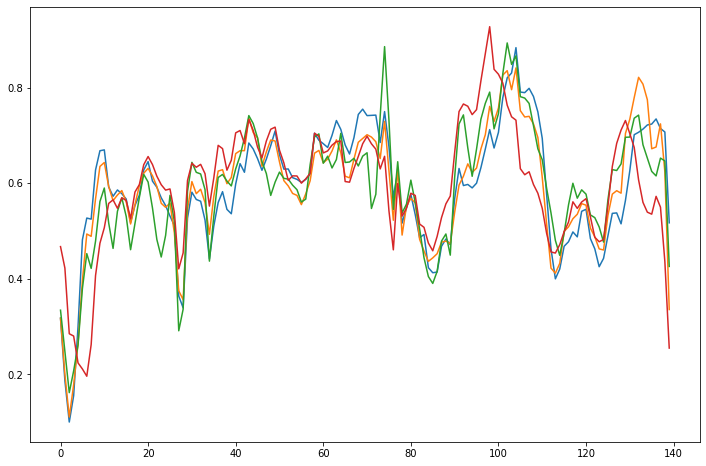

In [20]:
plt.figure(figsize=(12,8)) 
plt.plot(normal_X_train[0])
plt.plot(normal_X_train[1])
plt.plot(normal_X_train[2])
plt.plot(normal_X_train[3])

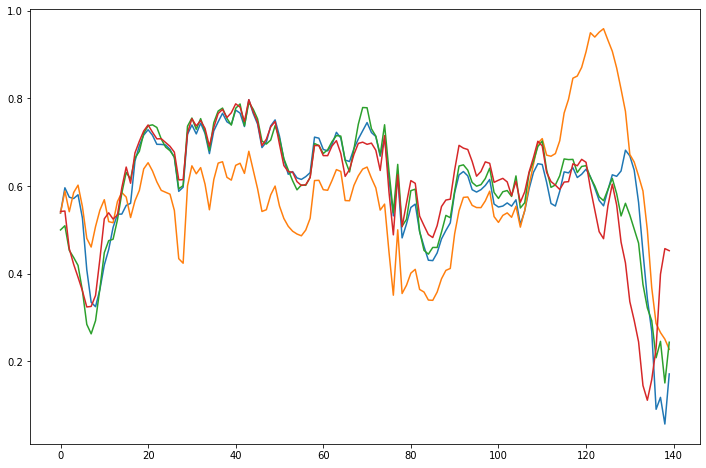

In [21]:
plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_train[0])
plt.plot(anomaly_X_train[1])
plt.plot(anomaly_X_train[2])
plt.plot(anomaly_X_train[3])

Usually we do not have access to well labeled datasets, but have to frame the problem as an unsupervised learning process. But how can we use an autoencoder in this setting? The objective of an autoencoder is to minimize the reconstruction error of a given input. We will therefore train an autoencoder solely on the normal ecg sequences, such that it reconstructs these examples with minimal error. The idea now is the following: Abnormal rhythms should have a higher reconstruction error as the normal sequences, allowing us to classify a rhythm as an anomaly if the reconstruction error is higher than a fixed threshold.



In [22]:
normal_X_train.shape

(2333, 140)

In [23]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    # Define the encoder network
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    # Define the decoder network
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    # Define how an evaluation of the network is performed
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [24]:
autoencoder = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=3,
                    mode='min',)

autoencoder.compile(optimizer='adam', loss='mae')

In [25]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
                    epochs=100,
                    batch_size=256,
                    validation_data=(normal_X_test, normal_X_test),
                    callbacks=[early_stopping],
                    shuffle=True)

Epoch 1/100
10/10 [==============================] - 2s 61ms/step - loss: 0.1264 - val_loss: 0.1194
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.1072 - val_loss: 0.0936
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0829 - val_loss: 0.0719
Epoch 4/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0640 - val_loss: 0.0589
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0541 - val_loss: 0.0530
Epoch 6/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0496 - val_loss: 0.0504
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0477 - val_loss: 0.0493
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0470 - val_loss: 0.0489
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0466 - val_loss: 0.0487
Epoch 10/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0465 - val_loss: 0.0486

In [26]:
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 11768     
                                                                 
 sequential_1 (Sequential)   (None, 140)               11900     
                                                                 
Total params: 23,668
Trainable params: 23,668
Non-trainable params: 0
_________________________________________________________________


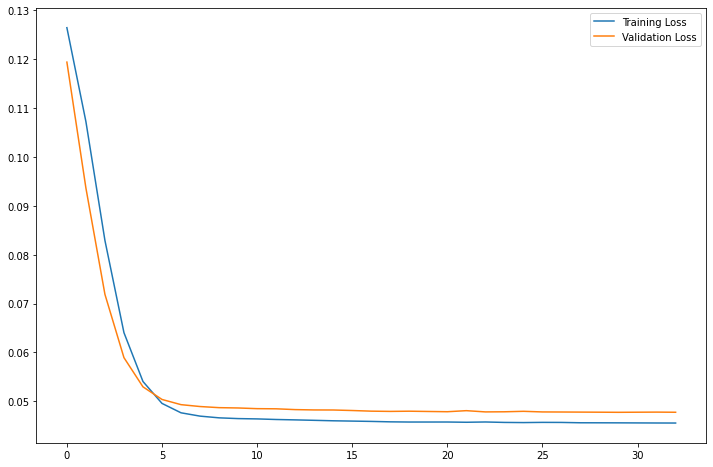

In [27]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

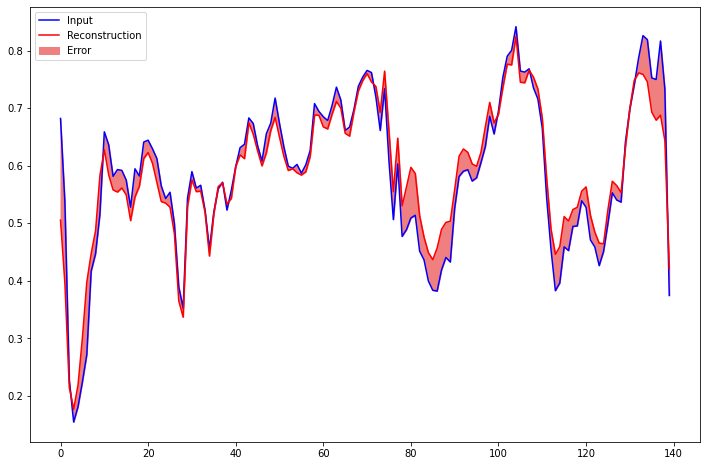

In [28]:
encoded_data = autoencoder.encoder(normal_X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

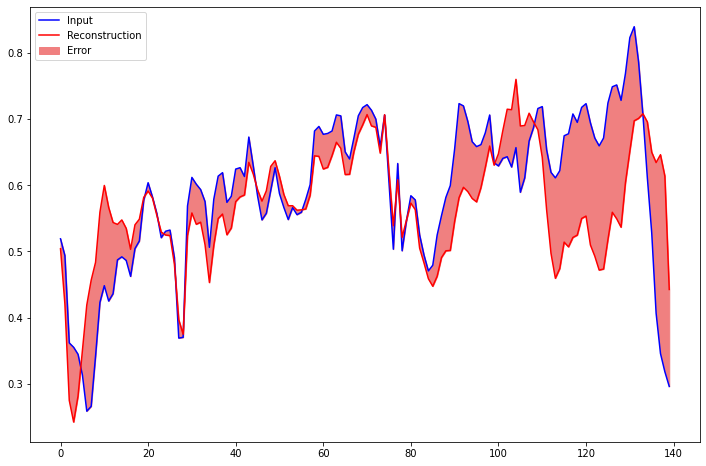

In [29]:
encoded_data = autoencoder.encoder(anomaly_X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Finding threshold

As we can see, the normal data is fitted pretty accurately, whilst the abnormal data does not really copy the original data.

And that's what we are focusing at. We can now compute the mean square error mse or mean absolute error mae of the normal and abnormal data, plot their distribution and based on that decide where the threshold should be, so let's get into it!

In [30]:
reconstruction = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

73/73 [==============================] - 1s 4ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

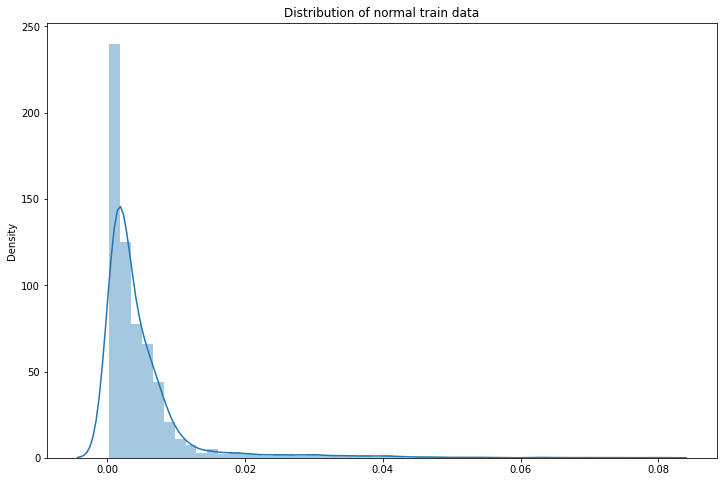

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [32]:
mean_normal = np.mean(train_loss)

std_normal = np.std(train_loss)

In [33]:
threshold = mean_normal + std_normal
print("Threshold: ", threshold)

Threshold:  0.01212713133080343


## Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:
- If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal test data

In [34]:
reconstruction_test = autoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

19/19 [==============================] - 0s 10ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

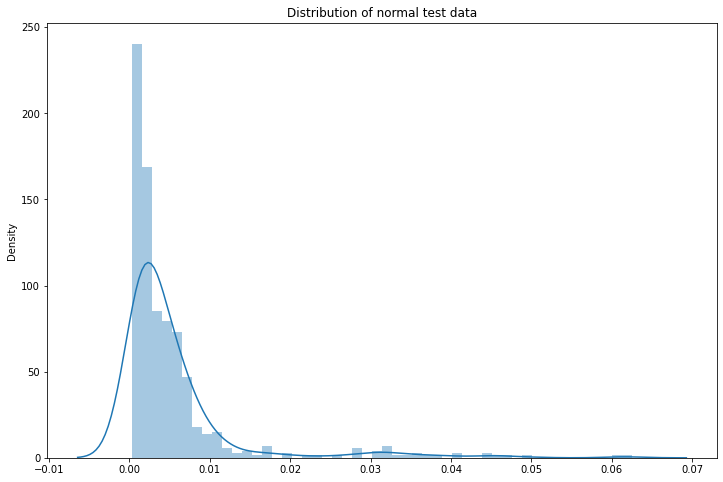

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

In [36]:
correct = [l <= threshold for l in test_loss_normal.numpy()]
print(f'Correct normal predictions: {np.count_nonzero(correct)}/{len(normal_X_test)}')

Correct normal predictions: 542/586


### Anomalous test data

In [37]:
reconstruction_anomalies = autoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

13/13 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

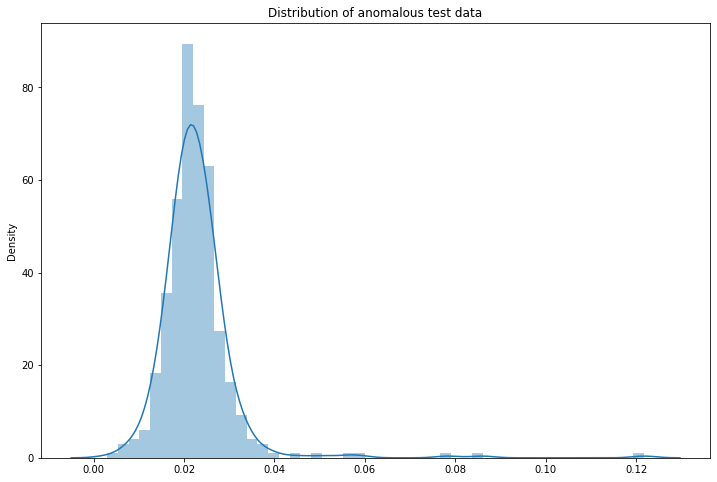

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

In [39]:
correct = [l > threshold for l in test_loss_anomalies.numpy()]
print(f'Correct anomaly predictions: {np.count_nonzero(correct)}/{len(anomaly_X_test)}')

Correct anomaly predictions: 403/414


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


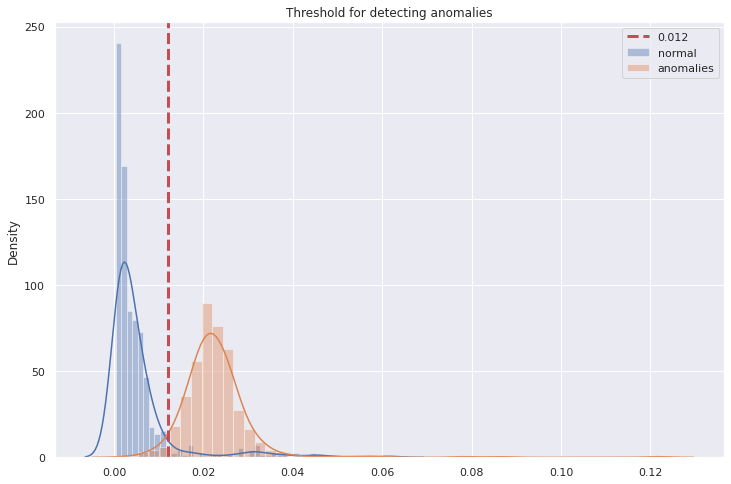

In [40]:
sns.set(rc={'figure.figsize':(12,8)})

# plot histograms of normal and abnormal data

sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomalies')

# plot a vertical line, which displays the threshold

plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

# add a legend and title

plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

## Confusion matrix, ROC curve

To be able to plot the confusion matrix and ROC curve we first need to count how many errors I. and II. we have -> how many false positives or false negatives.
For this we are going to use the tf.math function, where we compare the threshold with the test losses of normal and abnormal data and get an array with True/False values.
Next we count how many manu nonzero values we have (non-zero = 1 = True).

In [41]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)
# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)

In [42]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_X_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(542, 44)

In [43]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = anomaly_X_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(403, 11)

To plot the confusion matrix, we need to create a list which will hold the values we want to display.
We can also define the categories to display as ticks - normal/anomalities.
And to plot the data we will use seaborn. Seaborn is a library for statistical data visualization and is based on matplotlib, but is more user friendly. Basicly all we could do is to write sns.heatmap(cm) and we would have our confusion matrix. However we added few extras to make it nice and representable.

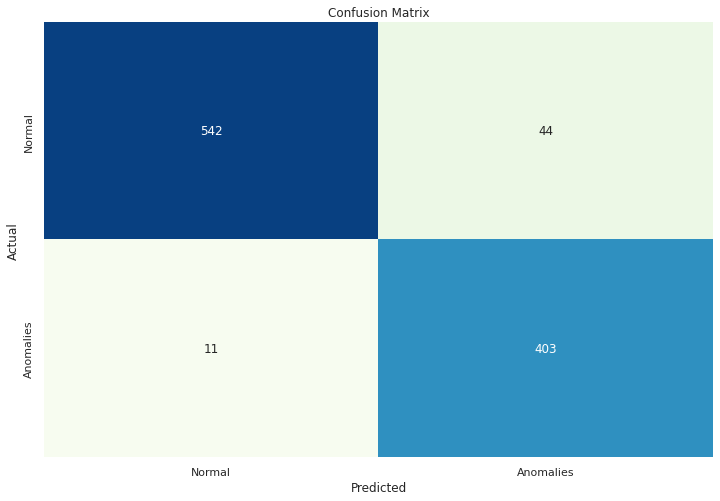

In [44]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

# cm = [[pred_anomaly_true, pred_anomaly_false]
#       [pred_normal_false, pred_normal_true]]

categories = ['Normal', 'Anomalies']

g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cbar=False, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we combine the first three cells of this block into one as a function which will predict true positives, false negatives, true negatives and false positives. We will need this function to get us values, so we can plot ROC.

In [45]:
def predictor(normal, abnormal, threshold):
   
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

Calculate the roc values - tpr and fpr...
...first define empty list which will hold the values
...then create a for loop which will take 100 values from 0 to 1 (use np.linspace(from, to, steps))
...now use the defined predictor function and, where the threshold is the value 0 to 1 of the forloop
...calculate the trp and frp for each iteration tpr = tp/(tp + fn) and fpr = fp/(fp + tn)
...append the tpr and fpr values in the roc list

In [46]:
tpr_values = []
fpr_values = []

for thresh in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predictor(test_loss_normal, 
                            test_loss_anomalies, 
                            thresh/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

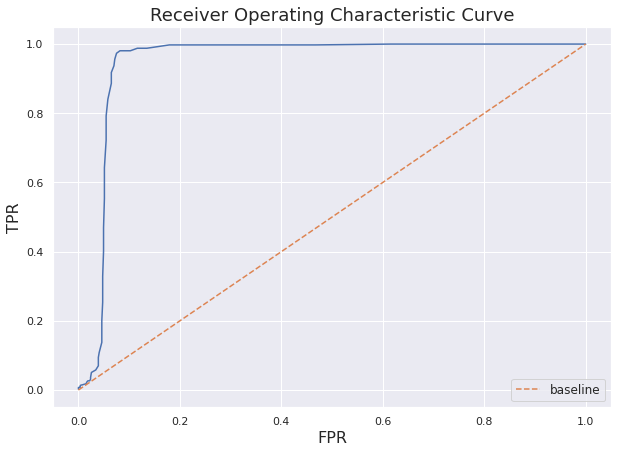

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

### Variational autoencoder

Autoencoders have a strong tendency to overfit on the training data. In class you got to know variational autoencoders, which are designed to mitigate this problem. First, define a function performing the sampling in the laten space using the reparametrization trick (this allows backpropagation of the gradient).

In [48]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [49]:
def encoder_model(normal_train_data):
    encoder_inputs = tf.keras.Input(shape=(normal_train_data.shape[1]))
    x = layers.Dense(32, activation="relu")(encoder_inputs)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    
    # So far we just copied the network from above
    # Now we generate the latent space of mean and log-variance, in this case of dimension 8
    z_mean = layers.Dense(8, name="z_mean")(x)
    z_log_var = layers.Dense(8, name="z_log_var")(x)
    
    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [50]:
def decoder_model(normal_train_data):
    # Recreate the network we used for the 'normal' autoencoder
    latent_inputs = tf.keras.Input(shape=(8,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    decoder_outputs = layers.Dense(normal_train_data.shape[1], activation="relu")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [51]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [52]:
# Get the encoder and decoder models
encoder = encoder_model(normal_X_train)
decoder = decoder_model(normal_X_train)

# Get the combined model
vae = VAE(encoder, decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Fit the model to the training set
history = vae.fit(normal_X_train, normal_X_train, 
          epochs=80, 
          batch_size=128,
          shuffle=True)

Epoch 1/80
19/19 [==============================] - 4s 17ms/step - loss: 4.2335 - reconstruction_loss: 4.2164 - kl_loss: 0.0170
Epoch 2/80
19/19 [==============================] - 0s 13ms/step - loss: 2.9625 - reconstruction_loss: 2.9543 - kl_loss: 0.0082
Epoch 3/80
19/19 [==============================] - 0s 12ms/step - loss: 2.2141 - reconstruction_loss: 2.1891 - kl_loss: 0.0249
Epoch 4/80
19/19 [==============================] - 0s 11ms/step - loss: 1.7147 - reconstruction_loss: 1.7109 - kl_loss: 0.0038
Epoch 5/80
19/19 [==============================] - 0s 13ms/step - loss: 1.4011 - reconstruction_loss: 1.4000 - kl_loss: 0.0011
Epoch 6/80
19/19 [==============================] - 0s 10ms/step - loss: 1.2130 - reconstruction_loss: 1.2119 - kl_loss: 0.0011
Epoch 7/80
19/19 [==============================] - 0s 8ms/step - loss: 1.1257 - reconstruction_loss: 1.1254 - kl_loss: 3.0227e-04
Epoch 8/80
19/19 [==============================] - 0s 11ms/step - loss: 1.0419 - reconstruction_loss

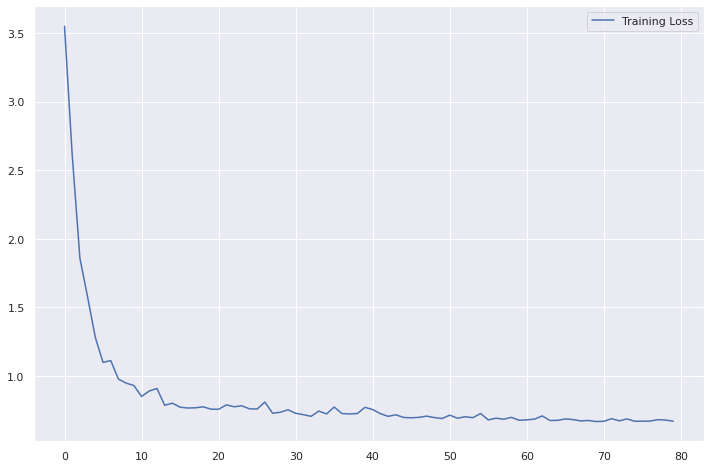

In [53]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

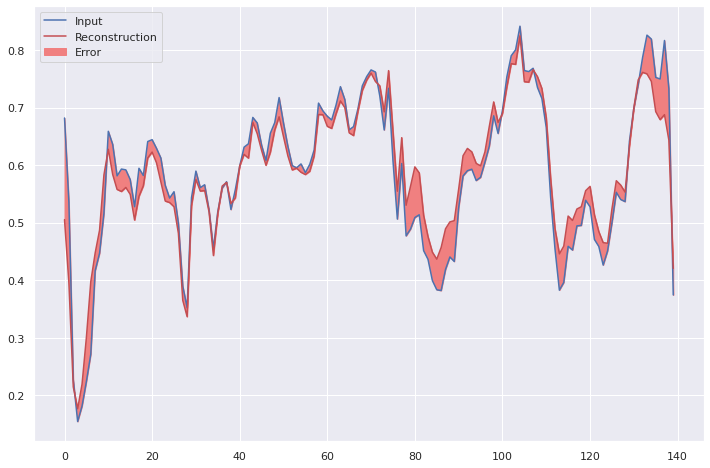

In [54]:
encoded_data_vae = autoencoder.encoder(normal_X_test).numpy()
decoded_data_vae = autoencoder.decoder(encoded_data_vae).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_data_vae[0], 'r')
plt.fill_between(np.arange(140), decoded_data_vae[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

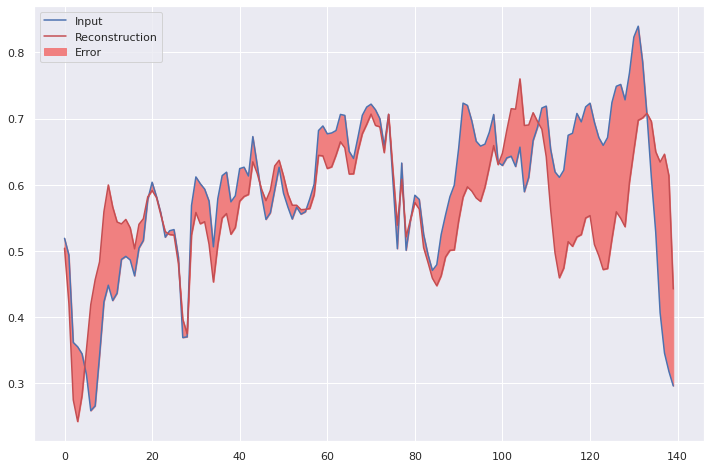

In [55]:
encoded_data_vae = autoencoder.encoder(anomaly_X_test).numpy()
decoded_data_vae = autoencoder.decoder(encoded_data_vae).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data_vae[0], 'r')
plt.fill_between(np.arange(140), decoded_data_vae[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### LSTM Autoencoder

In [56]:
train_data = np.expand_dims(normal_X_train,2)

In [58]:
train_data.shape

(2333, 140, 1)

In [59]:
# lstm autoencoder recreate sequence
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

'''class LSTMAutoEncoder(Model):
    def __init__(self):
      super(LSTMAutoEncoder, self).__init__()'''


# define model
LSTMAutoEncoder = tf.keras.Sequential()
LSTMAutoEncoder.add(LSTM(32, activation='relu', input_shape=(140,1), return_sequences=True))
LSTMAutoEncoder.add(LSTM(16, activation='relu', return_sequences=False))
LSTMAutoEncoder.add(RepeatVector(140))
LSTMAutoEncoder.add(LSTM(16, activation='relu', return_sequences=True))
LSTMAutoEncoder.add(LSTM(32, activation='relu', return_sequences=True))
LSTMAutoEncoder.add(TimeDistributed(Dense(normal_X_train.shape[1])))
LSTMAutoEncoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 140, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 140, 16)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 140, 16)           2112      
                                                                 
 lstm_3 (LSTM)               (None, 140, 32)           6272      
                                                                 
 time_distributed (TimeDistr  (None, 140, 140)         4620      
 ibuted)                                              

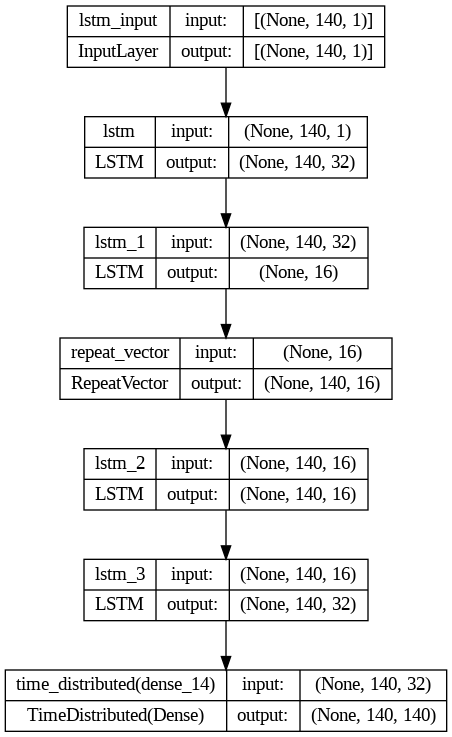

In [60]:
plot_model(LSTMAutoEncoder, show_shapes=True)

In [61]:
LSTMAutoEncoder.compile(optimizer='adam', loss='mae')

# fit model
LSTMAutoEncoder.fit(train_data, train_data, epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
19/19 [==============================] - 11s 289ms/step - loss: 0.5733
Epoch 2/20
19/19 [==============================] - 5s 277ms/step - loss: 44.6290
Epoch 3/20
19/19 [==============================] - 5s 271ms/step - loss: 0.4360
Epoch 4/20
19/19 [==============================] - 5s 263ms/step - loss: 0.4001
Epoch 5/20
19/19 [==============================] - 5s 263ms/step - loss: 0.3642
Epoch 6/20
19/19 [==============================] - 5s 276ms/step - loss: 0.2208
Epoch 7/20
19/19 [==============================] - 6s 320ms/step - loss: 0.1826
Epoch 8/20
19/19 [==============================] - 8s 413ms/step - loss: 0.1418
Epoch 9/20
19/19 [==============================] - 5s 262ms/step - loss: 0.1176
Epoch 10/20
19/19 [==============================] - 5s 266ms/step - loss: 0.1071
Epoch 11/20
19/19 [==============================] - 5s 288ms/step - loss: 0.1036
Epoch 12/20
19/19 [==============================] - 6s 307ms/step - loss: 0.1027
Epoch 13/20
19/19 [====

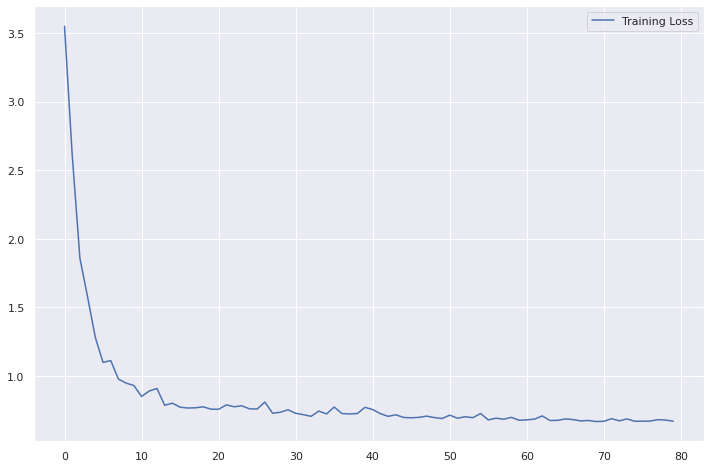

In [62]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()